In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import Image
# default: 100
mpl.rcParams['figure.dpi'] = 150

In [2]:
torch.manual_seed(42)

### basics

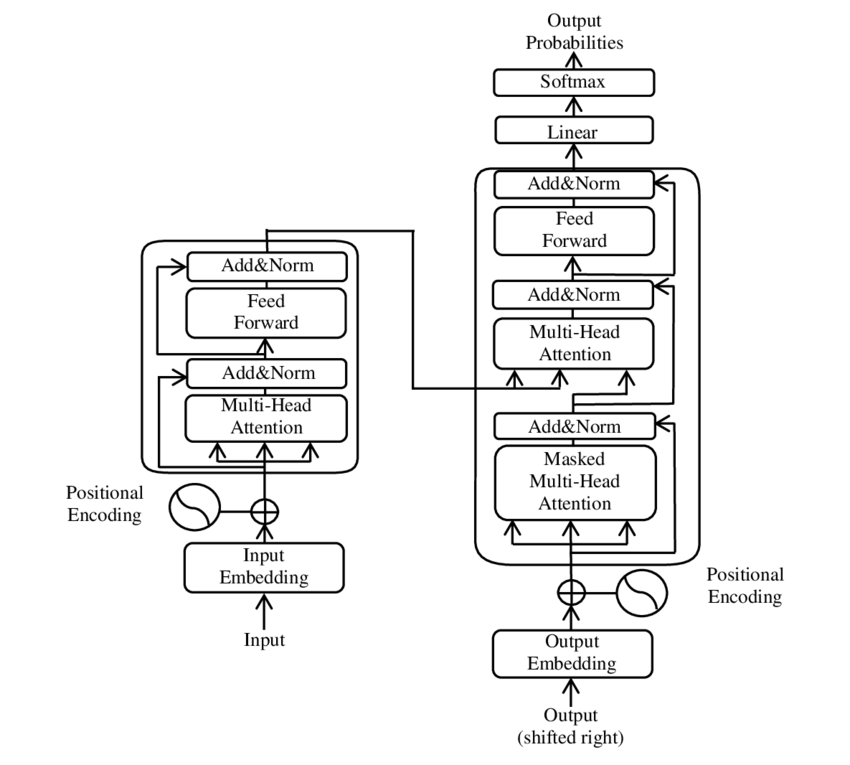

In [3]:
Image('../../imgs/The-Transformer-model-architecture.png')

- **pytorch transformer** (seq modeling) => transformers (hf, focus on language models) => LLM
- pytorch
    - `nn.TransformerEncoderLayer` => `nn.TransformerEncoder`
      - TransformerEncoder is a stack of N encoder layers.
      - BERT
    - `nn.TransformerDecoderLayer` => `nn.TransformerDecoder`
      - TransformerDecoder is a stack of N decoder layers.
      - GPT
- decoder 与 encoder 相比，有两个特殊的 attention sublayers
    - masked multi-head (**self**) attention
    - encoder-decoder (**cross**) attention
        - (k, v) from encoder （**memory**, last encoder layer）
        - q：decoder input
        - `multihead_attn(x, mem, mem)` from `TransformerDecoderLayer`
    - 两者权值不共享

#### (masked) multi-head attention

https://pytorch.org/docs/stable/generated/torch.nn.functional.scaled_dot_product_attention.html

- Encoder Self-Attention:
    - **No Masking:**
      - Since `attn_bias` is zero, the attention weights depend solely on the scaled dot product:
        $$
        \text{Scores}_{\text{encoder}} = \frac{Q K^\top}{\sqrt{d_k}}
        $$
        $$
        \text{Attention}_{\text{encoder}} = \text{softmax}(\text{Scores}_{\text{encoder}})
        $$
      - Each token attends to all tokens, including future ones.
- Decoder Masked Self-Attention:
    - **Causal Masking:**
      - The mask `M` is defined as:
        $$
        M_{i,j} = 
        \begin{cases} 
          0 & \text{if } j \leq i \\
          -\infty & \text{if } j > i 
        \end{cases}
        $$
      - The attention scores become:
        $$
        \text{Scores}_{\text{decoder}} = \frac{Q K^\top}{\sqrt{d_k}} + M
        $$
      - Applying softmax:
        $$
        \text{Attention}_{\text{decoder}} = \text{softmax}(\text{Scores}_{\text{decoder}})
        $$
        - The `-inf` in `M` ensures that positions where \( j > i \) (future positions) have zero attention weight.


### encoder layer & encoder

- input: $\mathbf{X} \in \mathbb{R}^{T \times B \times d_{\text{model}}}$
- 1. multihead selfattn
    - 线性变换（linear projection, 矩阵乘法）生成 Q、K、V矩阵
    - $X_{\text{flat}}=\mathbf X.\text{reshape}(T\times B,d_{model})$
    - $\mathbf{QKV}=\mathbf X\mathbf W_{in}^T+\mathbf b_{in}$（`encoder_layer.self_attn.in_proj_weight`, `encoder_layer.self_attn.in_proj_bias`）
        - $\mathbf{W}_{in} \in \mathbb{R}^{3d_{\text{model}} \times d_{\text{model}}}$，$\mathbf{b}_{in} \in \mathbb{R}^{3d_{\text{model}}}$
        - $\mathbf{QKV}\in \mathbb R^{T\times B,3d_{model}}$
    - 拆分 $\mathbf Q, \mathbf K,\mathbf V$
        - $\mathbf Q, \mathbf K,\mathbf V=\text{split}(\mathbf{QKV},d_{model})$（按列进行拆分）
        - $\mathbf Q, \mathbf K,\mathbf V\in \mathbb R^{T \times B, d_{\text{model}}}$
    - 调整形状以适应多头注意力
        - $d_k = \frac{d_{\text{model}}}h$
        - `reshape_for_heads`
        $$
        \begin{align*}
            \mathbf{Q}_{\text{heads}} &= \mathbf{Q}.\text{reshape}(T, B, h, d_k).\text{permute}(1, 2, 0, 3).\text{reshape}(B \times h, T, d_k) \\
            \mathbf{K}_{\text{heads}} &= \mathbf{K}.\text{reshape}(T, B, h, d_k).\text{permute}(1, 2, 0, 3).\text{reshape}(B \times h, T, d_k) \\
            \mathbf{V}_{\text{heads}} &= \mathbf{V}.\text{reshape}(T, B, h, d_k).\text{permute}(1, 2, 0, 3).\text{reshape}(B \times h, T, d_k)
        \end{align*}
        $$
    - 计算注意力分数：$\text{Scores} = \frac{\mathbf{Q}_{\text{heads}} \mathbf{K}_{\text{heads}}^\top}{\sqrt{d_k}}$
        - $\mathbf{Q}_{\text{heads}} \in \mathbb{R}^{(B \times h) \times T \times d_k}$，$\mathbf{K}_{\text{heads}}^\top \in \mathbb{R}^{(B \times h) \times d_k \times T}$，因此 $\text{Scores} \in \mathbb{R}^{(B \times h) \times T \times T}$。
    - 计算注意力权重：$\text{AttentionWeights}=\text{softmax}(\text{Scores})$
    - 计算注意力输出：$\text{AttentionOutput}=\text{AttentionWeights}\times{\mathbf V_\text{heads}}$
        - $\mathbf{V}_{\text{heads}} \in \mathbb{R}^{(B \times h) \times T \times d_k}$，因此 $\text{AttentionOutput} \in \mathbb{R}^{(B \times h) \times T \times d_k}$。
    - 合并多头输出：$\text{AttentionOutput} = \text{AttentionOutput}.\text{reshape}(B, h, T, d_k).\text{permute}(2, 0, 1, 3).\text{reshape}(T, B, d_{\text{model}})$
    - 输出线性变换：$\text{AttnOutputProjected} = \text{AttentionOutput} \mathbf{W}_{\text{out}}^\top + \mathbf{b}_{\text{out}}$
        - $\mathbf{W}_{\text{out}} \in \mathbb{R}^{d{_\text{model}} \times d_{\text{model}}}$，$\mathbf{b}_{\text{out}} \in \mathbb{R}^{d_{\text{model}}}$，对应代码中的`out_proj_weight`和`out_proj_bias`。
- 2. 残差连接和层归一化（第一层）
    - 残差连接：$\text{Residual1} = \mathbf{X} + \text{AttnOutputProjected}$
    - 层归一化：$\text{Normalized1} = \text{LayerNorm}(\text{Residual1}, \gamma_{\text{norm1}}, \beta_{\text{norm1}})$
        - $\gamma_{\text{norm1}}, \beta_{\text{norm1}} \in \mathbb{R}^{d_{\text{model}}}$，对应代码中的`norm1.weight` 和 `norm1.bias`。
- 3. 前馈神经网络 (ffn)
    - 第一层线性变换和激活函数：$\text{FFNOutput1} = \text{ReLU}(\text{Normalized1} \mathbf{W}_1^\top + \mathbf{b}_1)$
        - 其中，$\mathbf{W}_1 \in \mathbb{R}^{d_{\text{ff}} \times d_{\text{model}}}$，$\mathbf{b}_1 \in \mathbb{R}^{d_{\text{ff}}}$，对应代码中的 `linear1.weight` 和`linear1.bias`。
    - 第二层线性变换：$\text{FFNOutput2} = \text{FFNOutput1} \mathbf{W}_2^\top + \mathbf{b}_2$
        - 其中，$\mathbf{W}_2 \in \mathbb{R}^{d_{\text{model}} \times d_{\text{ff}}}$，$\mathbf{b}_2 \in \mathbb{R}^{d_{\text{model}}}$，对应代码中的 `linear2.weight` 和 `linear2.bias`。
- 4. 残差连接和层归一化（第二层）
    - 残差连接：$\text{Residual2} = \text{Normalized1} + \text{FFNOutput2}$
    - 层归一化：$\text{Output} = \text{LayerNorm}(\text{Residual2}, \gamma_{\text{norm2}}, \beta_{\text{norm2}})$
        - 其中，$\gamma_{\text{norm2}}, \beta_{\text{norm2}} \in \mathbb{R}^{d_{\text{model}}}$，对应代码中的 `norm2.weight` 和 `norm2.bias`。

In [4]:
d_model = 4  # 模型维度
nhead = 2    # 多头注意力中的头数
dim_feedforward = 8  # 前馈网络的维度
batch_size = 1
seq_len = 3

In [5]:
assert d_model % nhead == 0

In [6]:
encoder_input = torch.randn(seq_len, batch_size, d_model)  # [seq_len, batch_size, d_model]

In [7]:
# 禁用 droput
encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                           dim_feedforward=dim_feedforward, dropout=0.0)

In [8]:
memory = encoder_layer(encoder_input)  # 编码器输出
memory

tensor([[[-1.0328, -0.9185,  0.6710,  1.2804]],

        [[-1.4175, -0.1948,  1.3775,  0.2347]],

        [[-1.0022, -0.8035,  0.3029,  1.5028]]],
       grad_fn=<NativeLayerNormBackward0>)

In [9]:
encoder_input.shape, memory.shape

(torch.Size([3, 1, 4]), torch.Size([3, 1, 4]))

### encoder manual

In [10]:
encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
  )
  (linear1): Linear(in_features=4, out_features=8, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (linear2): Linear(in_features=8, out_features=4, bias=True)
  (norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.0, inplace=False)
  (dropout2): Dropout(p=0.0, inplace=False)
)

#### input reshape

In [11]:
X = encoder_input  # [3, 1, 4]
X.shape

torch.Size([3, 1, 4])

In [12]:
X_flat = X.contiguous().view(-1, d_model)  # [T * B, d_model] -> [3, 4]
X_flat.shape

torch.Size([3, 4])

#### 多头注意力层

In [13]:
self_attn = encoder_layer.self_attn

In [14]:
# d_model = 4
# (3d_model, d_model), (3d_model)
self_attn.in_proj_weight.shape, self_attn.in_proj_bias.shape

(torch.Size([12, 4]), torch.Size([12]))

In [15]:
# d_model = 4
# (d_model, d_model), (d_model) 
self_attn.out_proj.weight.shape, self_attn.out_proj.bias.shape

(torch.Size([4, 4]), torch.Size([4]))

In [16]:
W_in = self_attn.in_proj_weight
b_in = self_attn.in_proj_bias

W_out = self_attn.out_proj.weight
b_out = self_attn.out_proj.bias

In [17]:
QKV = F.linear(X_flat, W_in, b_in)  # [3, 3*d_model]
QKV.shape

torch.Size([3, 12])

In [18]:
Q, K, V = QKV.split(d_model, dim=1)  # 每个维度为[3, d_model]
Q.shape, K.shape, V.shape

(torch.Size([3, 4]), torch.Size([3, 4]), torch.Size([3, 4]))

In [19]:
# 调整Q、K、V的形状以适应多头注意力
head_dim = d_model // nhead  # 每个头的维度
def reshape_for_heads(x):
    return x.contiguous().view(seq_len, batch_size, nhead, head_dim).permute(1, 2, 0, 3).reshape(batch_size * nhead, seq_len, head_dim)

In [20]:
Q = reshape_for_heads(Q)
K = reshape_for_heads(K)
V = reshape_for_heads(V)

In [21]:
# B*h, T, d_k
Q.shape, K.shape, V.shape

(torch.Size([2, 3, 2]), torch.Size([2, 3, 2]), torch.Size([2, 3, 2]))

In [22]:
# 计算注意力分数
scores = torch.bmm(Q, K.transpose(1, 2)) / (head_dim ** 0.5)  # [batch_size * nhead, seq_len, seq_len]

# 应用softmax
attn_weights = F.softmax(scores, dim=-1)  # [batch_size * nhead, seq_len, seq_len]

# 计算注意力输出
attn_output = torch.bmm(attn_weights, V)  # [batch_size * nhead, seq_len, head_dim]

# 调整形状以合并所有头的输出
attn_output = attn_output.view(batch_size, nhead, seq_len, head_dim).permute(2, 0, 1, 3).contiguous()
attn_output = attn_output.view(seq_len, batch_size, d_model)  # [seq_len, batch_size, d_model]

# 通过输出投影层
attn_output = F.linear(attn_output.view(-1, d_model), W_out, b_out)  # [seq_len * batch_size, d_model]
attn_output = attn_output.view(seq_len, batch_size, d_model)

In [23]:
attn_weights.sum(dim=-1)

tensor([[1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000]], grad_fn=<SumBackward1>)

#### 残差连接和层归一化（第一层）

In [24]:
norm1 = encoder_layer.norm1

In [25]:
residual = X + attn_output  # [seq_len, batch_size, d_model]
normalized = F.layer_norm(residual, (d_model,), weight=norm1.weight, bias=norm1.bias)  # [seq_len, batch_size, d_model]

#### 通过前馈神经网络

In [26]:
W_1 = encoder_layer.linear1.weight
b_1 = encoder_layer.linear1.bias

W_2 = encoder_layer.linear2.weight
b_2 = encoder_layer.linear2.bias

norm2 = encoder_layer.norm2

In [27]:
ffn_output = F.linear(normalized.view(-1, d_model), W_1, b_1)  # [seq_len * batch_size, dim_feedforward]
ffn_output = F.relu(ffn_output)  # [seq_len * batch_size, dim_feedforward]

# 第二层线性变换
ffn_output = F.linear(ffn_output, W_2, b_2)  # [seq_len * batch_size, d_model]
ffn_output = ffn_output.view(seq_len, batch_size, d_model)  # [seq_len, batch_size, d_model]

# 残差连接和层归一化（第二层）
residual2 = normalized + ffn_output  # [seq_len, batch_size, d_model]
normalized2 = F.layer_norm(residual2, (d_model,), weight=norm2.weight, bias=norm2.bias)  # [seq_len, batch_size, d_model]

In [28]:
normalized2

tensor([[[-1.0328, -0.9185,  0.6710,  1.2804]],

        [[-1.4175, -0.1948,  1.3775,  0.2347]],

        [[-1.0022, -0.8035,  0.3029,  1.5028]]],
       grad_fn=<NativeLayerNormBackward0>)

In [29]:
torch.allclose(normalized2, memory)

True

### decoder layer & decoder

- **Input**: $\mathbf{Y} \in \mathbb{R}^{T_{\text{dec}} \times B \times d_{\text{model}}}$（解码器输入）
    - self-attention，自注意力, 作为 Q_cross
- **Memory**: $\mathbf{M} \in \mathbb{R}^{T_{\text{enc}} \times B \times d_{\text{model}}}$（编码器输出）
    - cross-attention，交叉注意力，作为 KV_cross

- **1. Multi-head Self-Attention（解码器的多头自注意力）**
    - **线性变换**（生成 $\mathbf{Q}_{\text{self}}$、$\mathbf{K}_{\text{self}}$、$\mathbf{V}_{\text{self}}$）
        - 将 $\mathbf{Y}$ 展平为二维矩阵：
            - $Y_{\text{flat}} = \mathbf{Y}.\text{reshape}(T_{\text{dec}} \times B, d_{\text{model}})$
        - 计算查询、键、值矩阵：
            - $\mathbf{QKV}_{\text{self}} = Y_{\text{flat}} \mathbf{W}_{\text{in,self}}^\top + \mathbf{b}_{\text{in,self}}$
                - $\mathbf{W}_{\text{in,self}} \in \mathbb{R}^{3d_{\text{model}} \times d_{\text{model}}}$，$\mathbf{b}_{\text{in,self}} \in \mathbb{R}^{3d_{\text{model}}}$
            - 拆分：
                - $\mathbf{Q}_{\text{self}}$, $\mathbf{K}_{\text{self}}$, $\mathbf{V}_{\text{self}} = \text{split}(\mathbf{QKV}_{\text{self}}, d_{\text{model}})$
    - **调整形状以适应多头注意力**
        - 定义每个头的维度：
            - $d_k = \frac{d_{\text{model}}}{h}$
        - 使用 `reshape_for_heads` 函数：
            $$
            \begin{align*}
                \mathbf{Q}_{\text{heads,self}} &= \mathbf{Q}_{\text{self}}.\text{reshape}(T_{\text{dec}}, B, h, d_k). \\
                &\quad\quad\text{permute}(1, 2, 0, 3). \\
                &\quad\quad\text{reshape}(B \times h, T_{\text{dec}}, d_k) \\
                \mathbf{K}_{\text{heads,self}} &= \mathbf{K}_{\text{self}}.\text{reshape}(T_{\text{dec}}, B, h, d_k). \\
                &\quad\quad\text{permute}(1, 2, 0, 3). \\
                &\quad\quad\text{reshape}(B \times h, T_{\text{dec}}, d_k) \\
                \mathbf{V}_{\text{heads,self}} &= \mathbf{V}_{\text{self}}.\text{reshape}(T_{\text{dec}}, B, h, d_k). \\
                &\quad\quad\text{permute}(1, 2, 0, 3). \\
                &\quad\quad\text{reshape}(B \times h, T_{\text{dec}}, d_k)
            \end{align*}
            $$
    - **计算注意力分数**
        - 计算缩放点积注意力分数：
            - $\text{Scores}_{\text{self}} = \frac{\mathbf{Q}_{\text{heads,self}} \mathbf{K}_{\text{heads,self}}^\top}{\sqrt{d_k}}$
        - **（可选）应用遮掩矩阵**
            - 如果需要防止解码器看到未来的信息，创建遮掩矩阵 $\text{Mask} \in \mathbb{R}^{T_{\text{dec}} \times T_{\text{dec}}}$，在上三角位置填充 $-\infty$，否则为 $0$。
            - 应用遮掩：$\text{Scores}_{\text{self}} = \text{Scores}_{\text{self}} + \text{Mask}$
    - **计算注意力权重和输出**
        - 注意力权重：
            - $\text{AttentionWeights}_{\text{self}} = \text{softmax}(\text{Scores}_{\text{self}})$
        - 注意力输出：
            - $\text{AttentionOutput}_{\text{self}} = \text{AttentionWeights}_{\text{self}} \times \mathbf{V}_{\text{heads,self}}$
    - **合并多头输出并线性变换**
        - 合并多头输出：
            $$
            \text{AttentionOutput}_{\text{self}} = \text{AttentionOutput}_{\text{self}}.\text{reshape}(B, h, T_{\text{dec}}, d_k). \\
            \text{permute}(2, 0, 1, 3). \\
            \text{reshape}(T_{\text{dec}}, B, d_{\text{model}})
            $$
        - 输出线性变换：
            - $\text{AttnOutputProjected}_{\text{self}} = \text{AttentionOutput}_{\text{self}} \mathbf{W}_{\text{out,self}}^\top + \mathbf{b}_{\text{out,self}}$
                - $\mathbf{W}_{\text{out,self}} \in \mathbb{R}^{d_{\text{model}} \times d_{\text{model}}}$，$\mathbf{b}_{\text{out,self}} \in \mathbb{R}^{d_{\text{model}}}$
    
- **2. 残差连接和层归一化（第一层）**
    - 残差连接：
        - $\text{Residual1} = \mathbf{Y} + \text{AttnOutputProjected}_{\text{self}}$
    - 层归一化：
        - $\text{Normalized1} = \text{LayerNorm}(\text{Residual1}, \gamma_{\text{norm1}}, \beta_{\text{norm1}})$
            - $\gamma_{\text{norm1}}, \beta_{\text{norm1}} \in \mathbb{R}^{d_{\text{model}}}$
    
- **3. Multi-head Encoder-Decoder Attention（交叉注意力）**
    - **线性变换生成 $\mathbf{Q}_{\text{cross}}$、$\mathbf{K}_{\text{cross}}$、$\mathbf{V}_{\text{cross}}$**
        - **查询矩阵 $\mathbf{Q}_{\text{cross}}$（来自解码器）**
            - 将 $\text{Normalized1}$ 展平：
                - $\text{Normalized1}_{\text{flat}} = \text{Normalized1}.\text{reshape}(T_{\text{dec}} \times B, d_{\text{model}})$
            - 线性变换：
                - $\mathbf{Q}_{\text{cross}} = \text{Normalized1}_{\text{flat}} \mathbf{W}_{\text{q,cross}}^\top + \mathbf{b}_{\text{q,cross}}$
                    - $\mathbf{W}_{\text{q,cross}} \in \mathbb{R}^{d_{\text{model}} \times d_{\text{model}}}$，$\mathbf{b}_{\text{q,cross}} \in \mathbb{R}^{d_{\text{model}}}$
        - **键和值矩阵 $\mathbf{K}_{\text{cross}}$、$\mathbf{V}_{\text{cross}}$（来自编码器）**
            - 将 $\mathbf{M}$ 展平：
                - $\mathbf{M}_{\text{flat}} = \mathbf{M}.\text{reshape}(T_{\text{enc}} \times B, d_{\text{model}})$
            - 线性变换：
                - $\mathbf{KV}_{\text{cross}} = \mathbf{M}_{\text{flat}} \mathbf{W}_{\text{k,v,cross}}^\top + \mathbf{b}_{\text{k,v,cross}}$
                    - $\mathbf{W}_{\text{k,v,cross}} \in \mathbb{R}^{2d_{\text{model}} \times d_{\text{model}}}$，$\mathbf{b}_{\text{k,v,cross}} \in \mathbb{R}^{2d_{\text{model}}}$
                - 拆分：
                    - $\mathbf{K}_{\text{cross}}$, $\mathbf{V}_{\text{cross}} = \text{split}(\mathbf{KV}_{\text{cross}}, d_{\text{model}})$
    - **调整形状以适应多头注意力**
        - 使用 `reshape_for_heads` 函数：
            $$
            \begin{align*}
                \mathbf{Q}_{\text{heads,cross}} &= \mathbf{Q}_{\text{cross}}.\text{reshape}(T_{\text{dec}}, B, h, d_k). \\
                &\quad\quad\text{permute}(1, 2, 0, 3). \\
                &\quad\quad\text{reshape}(B \times h, T_{\text{dec}}, d_k) \\
                \mathbf{K}_{\text{heads,cross}} &= \mathbf{K}_{\text{cross}}.\text{reshape}(T_{\text{enc}}, B, h, d_k). \\
                &\quad\quad\text{permute}(1, 2, 0, 3). \\
                &\quad\quad\text{reshape}(B \times h, T_{\text{enc}}, d_k) \\
                \mathbf{V}_{\text{heads,cross}} &= \mathbf{V}_{\text{cross}}.\text{reshape}(T_{\text{enc}}, B, h, d_k). \\
                &\quad\quad\text{permute}(1, 2, 0, 3). \\
                &\quad\quad\text{reshape}(B \times h, T_{\text{enc}}, d_k)
            \end{align*}
            $$
    - **计算注意力分数**
        - 缩放点积注意力分数：
            - $\text{Scores}_{\text{cross}} = \frac{\mathbf{Q}_{\text{heads,cross}} \mathbf{K}_{\text{heads,cross}}^\top}{\sqrt{d_k}}$
    - **计算注意力权重和输出**
        - 注意力权重：
            - $\text{AttentionWeights}_{\text{cross}} = \text{softmax}(\text{Scores}_{\text{cross}})$
        - 注意力输出：
            - $\text{AttentionOutput}_{\text{cross}} = \text{AttentionWeights}_{\text{cross}} \times \mathbf{V}_{\text{heads,cross}}$
    - **合并多头输出并线性变换**
        - 合并多头输出：
            $$
            \text{AttentionOutput}_{\text{cross}} = \text{AttentionOutput}_{\text{cross}}.\text{reshape}(B, h, T_{\text{dec}}, d_k). \\
            \text{permute}(2, 0, 1, 3). \\
            \text{reshape}(T_{\text{dec}}, B, d_{\text{model}})
            $$
        - 输出线性变换：
            - $\text{AttnOutputProjected}_{\text{cross}} = \text{AttentionOutput}_{\text{cross}} \mathbf{W}_{\text{out,cross}}^\top + \mathbf{b}_{\text{out,cross}}$
                - $\mathbf{W}_{\text{out,cross}} \in \mathbb{R}^{d_{\text{model}} \times d_{\text{model}}}$，$\mathbf{b}_{\text{out,cross}} \in \mathbb{R}^{d_{\text{model}}}$
    
- **4. 残差连接和层归一化（第二层）**
    - 残差连接：
        - $\text{Residual2} = \text{Normalized1} + \text{AttnOutputProjected}_{\text{cross}}$
    - 层归一化：
        - $\text{Normalized2} = \text{LayerNorm}(\text{Residual2}, \gamma_{\text{norm2}}, \beta_{\text{norm2}})$
            - $\gamma_{\text{norm2}}, \beta_{\text{norm2}} \in \mathbb{R}^{d_{\text{model}}}$
    
- **5. 前馈神经网络（FFN）**
    - 第一层线性变换和激活函数：
        - $\text{FFNOutput1} = \text{ReLU}(\text{Normalized2} \mathbf{W}_1^\top + \mathbf{b}_1)$
            - $\mathbf{W}_1 \in \mathbb{R}^{d_{\text{ff}} \times d_{\text{model}}}$，$\mathbf{b}_1 \in \mathbb{R}^{d_{\text{ff}}}$
    - 第二层线性变换：
        - $\text{FFNOutput2} = \text{FFNOutput1} \mathbf{W}_2^\top + \mathbf{b}_2$
            - $\mathbf{W}_2 \in \mathbb{R}^{d_{\text{model}} \times d_{\text{ff}}}$，$\mathbf{b}_2 \in \mathbb{R}^{d_{\text{model}}}$
    
- **6. 残差连接和层归一化（第三层）**
    - 残差连接：
        - $\text{Residual3} = \text{Normalized2} + \text{FFNOutput2}$
    - 层归一化：
        - $\text{Output} = \text{LayerNorm}(\text{Residual3}, \gamma_{\text{norm3}}, \beta_{\text{norm3}})$
            - $\gamma_{\text{norm3}}, \beta_{\text{norm3}} \in \mathbb{R}^{d_{\text{model}}}$
    ```


#### nn.TransformerDecoderLayer

In [30]:
# 定义参数
d_model = 4  # 模型维度
nhead = 2    # 多头注意力中的头数
dim_feedforward = 8  # 前馈网络的维度
batch_size = 1

src_seq_len = 3
trg_seq_len = 5

# 构造输入
# [T, B, d]
encoder_input = torch.randn(src_seq_len, batch_size, d_model)  
decoder_input = torch.randn(trg_seq_len, batch_size, d_model)

In [31]:
encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, 
                                           nhead=nhead,
                                           dim_feedforward=dim_feedforward, 
                                           dropout=0.0)
decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, 
                                           nhead=nhead,
                                           dim_feedforward=dim_feedforward, 
                                           dropout=0.0)

In [32]:
memory = encoder_layer(encoder_input)  # 编码器输出
output = decoder_layer(decoder_input, memory)  # 解码器输出
output

tensor([[[ 1.4649, -1.2788, -0.4103,  0.2242]],

        [[ 0.6232,  0.8962,  0.1496, -1.6691]],

        [[ 1.5618, -0.2913, -0.0571, -1.2134]],

        [[-0.2098, -1.2188, -0.1372,  1.5658]],

        [[ 1.3691, -0.4594, -1.3211,  0.4114]]],
       grad_fn=<NativeLayerNormBackward0>)

In [33]:
encoder_input.shape, memory.shape, output.shape

(torch.Size([3, 1, 4]), torch.Size([3, 1, 4]), torch.Size([5, 1, 4]))

#### decoder manual

In [34]:
decoder_layer

TransformerDecoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
  )
  (multihead_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
  )
  (linear1): Linear(in_features=4, out_features=8, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (linear2): Linear(in_features=8, out_features=4, bias=True)
  (norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
  (norm3): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.0, inplace=False)
  (dropout2): Dropout(p=0.0, inplace=False)
  (dropout3): Dropout(p=0.0, inplace=False)
)

#### 计算多头自注意力机制（不使用遮掩矩阵）

In [35]:
self_attn = decoder_layer.self_attn
W_in, b_in = self_attn.in_proj_weight, self_attn.in_proj_bias
W_out, b_out = self_attn.out_proj.weight, self_attn.out_proj.bias
# (3d, d)
W_in.shape, b_in.shape, W_out.shape, b_out.shape

(torch.Size([12, 4]), torch.Size([12]), torch.Size([4, 4]), torch.Size([4]))

In [36]:
Y = decoder_input
Y_flat = Y.view(-1, d_model)

In [37]:
# xW^T + b: (T, d) * (d, 3d) + (3d, )
QKV = F.linear(Y_flat, W_in, b_in)
QKV.shape

torch.Size([5, 12])

In [38]:
Q_self, K_self, V_self = QKV.split(d_model, dim=1)
Q_self.shape, K_self.shape, V_self.shape

(torch.Size([5, 4]), torch.Size([5, 4]), torch.Size([5, 4]))

In [39]:
# 调整形状以适应多头注意力
head_dim = d_model // nhead
def reshape_for_heads(x):
    return x.view(trg_seq_len, batch_size, nhead, head_dim).permute(1, 2, 0, 3).reshape(batch_size * nhead, trg_seq_len, head_dim)

Q_self = reshape_for_heads(Q_self)
K_self = reshape_for_heads(K_self)
V_self = reshape_for_heads(V_self)

In [40]:
# [batch_size * nhead, trg_seq_len, trg_seq_len]
scores_self = torch.bmm(Q_self, K_self.transpose(1, 2)) / (head_dim ** 0.5)  
scores_self.shape

torch.Size([2, 5, 5])

In [41]:
attn_weights_self = F.softmax(scores_self, dim=-1)

In [42]:
attn_output_self = torch.bmm(attn_weights_self, V_self)  # [batch_size * nhead, seq_len, head_dim]

In [43]:
# 调整形状以合并所有头的输出
attn_output_self = attn_output_self.view(batch_size, nhead, trg_seq_len, head_dim).permute(2, 0, 1, 3).contiguous()
# [seq_len, batch_size, d_model]
attn_output_self = attn_output_self.view(trg_seq_len, batch_size, d_model) 

In [44]:
# 通过输出投影层
attn_output_self = F.linear(attn_output_self.view(-1, d_model), W_out, b_out)
attn_output_self = attn_output_self.view(trg_seq_len, batch_size, d_model)
attn_output_self.shape

torch.Size([5, 1, 4])

In [45]:
norm1 = decoder_layer.norm1

In [46]:
residual1 = Y + attn_output_self
normalized1 = F.layer_norm(residual1, (d_model,), weight=norm1.weight, bias=norm1.bias)

####  计算编码器-解码器多头注意力机制

In [47]:
normalized1_reshaped = normalized1.contiguous().view(-1, d_model)  # [trg_seq_len * batch_size, d_model]

In [48]:
decoder_layer

TransformerDecoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
  )
  (multihead_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
  )
  (linear1): Linear(in_features=4, out_features=8, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (linear2): Linear(in_features=8, out_features=4, bias=True)
  (norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
  (norm3): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.0, inplace=False)
  (dropout2): Dropout(p=0.0, inplace=False)
  (dropout3): Dropout(p=0.0, inplace=False)
)

In [49]:
multihead_attn = decoder_layer.multihead_attn

In [50]:
cross_W_in, cross_b_in = multihead_attn.in_proj_weight, multihead_attn.in_proj_bias
cross_W_out, cross_b_out = multihead_attn.out_proj.weight, multihead_attn.out_proj.bias
cross_W_in.shape, cross_b_in.shape, cross_W_out.shape, cross_b_out.shape

(torch.Size([12, 4]), torch.Size([12]), torch.Size([4, 4]), torch.Size([4]))

In [51]:
Q_cross = F.linear(normalized1_reshaped, cross_W_in[:d_model, :], cross_b_in[:d_model])

In [52]:
Q_cross.shape

torch.Size([5, 4])

In [53]:
memory_reshaped = memory.contiguous().view(-1, d_model)  # [seq_len_enc * batch_size, d_model]
memory_reshaped.shape

torch.Size([3, 4])

In [54]:
KV_cross = F.linear(memory_reshaped, cross_W_in[d_model:, :], cross_b_in[d_model:])  # [3, 2*d_model]
KV_cross.shape

torch.Size([3, 8])

In [55]:
K_cross, V_cross = KV_cross.split(d_model, dim=1)  # 每个维度为[3, d_model]

In [56]:
# 调整形状以适应多头注意力
def reshape_for_heads_mem(x):
    return x.view(src_seq_len, batch_size, nhead, head_dim).permute(1, 2, 0, 3).reshape(batch_size * nhead, src_seq_len, head_dim)

In [57]:
Q_cross = reshape_for_heads(Q_cross)
K_cross = reshape_for_heads_mem(K_cross)
V_cross = reshape_for_heads_mem(V_cross)
Q_cross.shape, K_cross.shape, V.shape

(torch.Size([2, 5, 2]), torch.Size([2, 3, 2]), torch.Size([2, 3, 2]))

In [58]:
# [batch_size * nhead, seq_len_dec, seq_len_enc]
scores_cross = torch.bmm(Q_cross, K_cross.transpose(1, 2)) / (head_dim ** 0.5)  
scores_cross.shape

torch.Size([2, 5, 3])

In [59]:
# 注意：编码器-解码器注意力不需要遮掩
attn_weights_cross = F.softmax(scores_cross, dim=-1)

In [60]:
attn_output_cross = torch.bmm(attn_weights_cross, V_cross)  # [batch_size * nhead, seq_len_dec, head_dim]

In [61]:
attn_output_cross.shape

torch.Size([2, 5, 2])

In [62]:
attn_output_cross = attn_output_cross.view(batch_size, nhead, trg_seq_len, head_dim).permute(2, 0, 1, 3).contiguous()
attn_output_cross = attn_output_cross.view(trg_seq_len, batch_size, d_model)  # [seq_len, batch_size, d_model]

In [63]:
# 通过输出投影层
attn_output_cross = F.linear(attn_output_cross.view(-1, d_model), cross_W_out, cross_b_out)
attn_output_cross = attn_output_cross.view(trg_seq_len, batch_size, d_model)

In [64]:
norm2 = decoder_layer.norm2

In [65]:
residual2 = normalized1 + attn_output_cross
normalized2 = F.layer_norm(residual2, (d_model,), weight=norm2.weight, bias=norm2.bias)
normalized2.shape

torch.Size([5, 1, 4])

In [66]:
decoder_layer

TransformerDecoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
  )
  (multihead_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
  )
  (linear1): Linear(in_features=4, out_features=8, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (linear2): Linear(in_features=8, out_features=4, bias=True)
  (norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
  (norm3): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.0, inplace=False)
  (dropout2): Dropout(p=0.0, inplace=False)
  (dropout3): Dropout(p=0.0, inplace=False)
)

In [67]:
linear1, linear2 = decoder_layer.linear1, decoder_layer.linear2
norm3 = decoder_layer.norm3

In [68]:
# 第一层线性变换和激活函数
ffn_output = F.linear(normalized2.view(-1, d_model), linear1.weight, linear1.bias)
ffn_output = F.relu(ffn_output)

# 第二层线性变换
ffn_output = F.linear(ffn_output, linear2.weight, linear2.bias)
ffn_output = ffn_output.view(trg_seq_len, batch_size, d_model)

# 残差连接和层归一化（第三层）
residual3 = normalized2 + ffn_output
normalized3 = F.layer_norm(residual3, (d_model,), weight=norm3.weight, bias=norm3.bias)

In [69]:
normalized3

tensor([[[ 1.4649, -1.2788, -0.4103,  0.2242]],

        [[ 0.6232,  0.8962,  0.1496, -1.6691]],

        [[ 1.5618, -0.2913, -0.0571, -1.2134]],

        [[-0.2098, -1.2188, -0.1372,  1.5658]],

        [[ 1.3691, -0.4594, -1.3211,  0.4114]]],
       grad_fn=<NativeLayerNormBackward0>)

In [70]:
torch.allclose(normalized3, output)

True